<h1 style = "text-align: center">Maize Disease Classification</h1>

<h4> Table of Contents </h4>

1. [Introduction](#1)
2. [Environment Setup](#2)
3. [Data](#3)
4. [Data Preprocessing](#4)
5. [Modeling](#5)
6. [Evaluation](#6)
7. [Conclusion](#7)

<h2 id = "1"> Introduction </h2>

In this notebook, It is aimed to classify maize diseases using Convolutional Neural Networks.

<h2 id = "2"> Environment Setup </h2>

In [1]:
import os
import glob
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Multiply, Concatenate, Add, Reshape
from keras.models import Model
from keras.applications import EfficientNetV2B0
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


<h2 id = "3"> Data </h2>

<table>
    <tr>
        <th>Class</th>
        <th>Training</th>
        <th>Testing</th>
    </tr>
    <tr>
        <td>Common Rust (0)</td>
        <td>1,073</td>
        <td>119</td>
    </tr>
    <tr>
        <td>Gray Leaf Spot (1)</td>
        <td>975</td>
        <td>109</td>
    </tr>
    <tr>
        <td>Healthy (2)</td>
        <td>1,046</td>
        <td>116</td>
    </tr>
    <tr>
        <td>Northern Leaf Blight (3)</td>
        <td>887</td>
        <td>98</td>
    </tr>
    <tr>
        <td>Phaeosphaeria Leaf Spot (4)</td>
        <td>1,244</td>
        <td>137</td>
    </tr>
    <tr>
        <td>Southern Rust (5)</td>
        <td>900</td>
        <td>98</td>
    </tr>


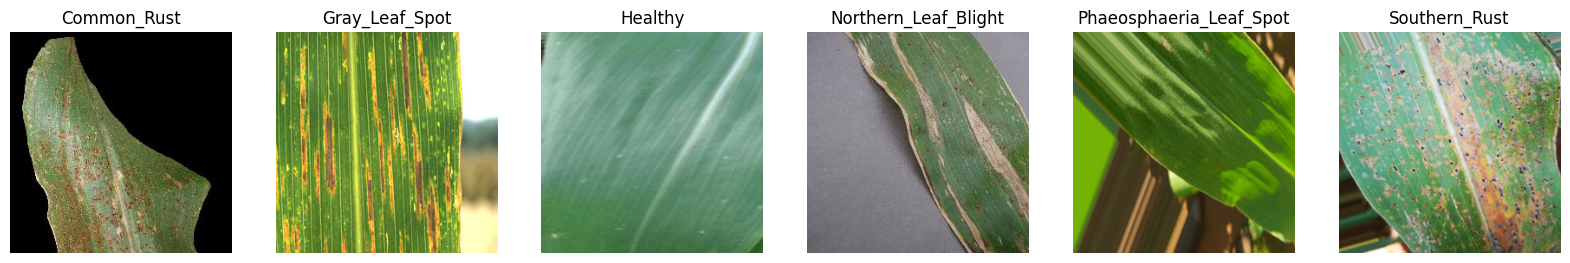

In [3]:
classes = {
    'Common_Rust': 0,
    'Gray_Leaf_Spot': 1,
    'Healthy': 2,
    'Northern_Leaf_Blight': 3,
    'Phaeosphaeria_Leaf_Spot': 4,
    'Southern_Rust': 5
}

def plot_images(folder_path):
    fig, axs = plt.subplots(1, 6, figsize=(20, 20))
    for i, folder in enumerate(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, folder, random.choice(os.listdir(os.path.join(folder_path, folder))))
        img = Image.open(img_path)
        img = img.resize((256, 256))
        axs[i].imshow(np.array(img))
        axs[i].set_title(folder)
        axs[i].axis('off')
    plt.show()

plot_images('data/train')

<h3> Data Preprocessing </h3>

<h4> Load Data </h4>

In [4]:
base_dir = 'data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

train_list = glob.glob(os.path.join(train_dir, '**', '*.jpg'), recursive=True)
test_list = glob.glob(os.path.join(test_dir, '**', '*.jpg'), recursive=True)

labels_train = [classes[os.path.basename(os.path.dirname(img))] for img in train_list]

print(f'Train images: {len(train_list)}')
print(train_list)
print(f'Test images: {len(test_list)}')
print(test_list)

Train images: 6125
['data\\train\\Common_Rust\\0_1.jpg', 'data\\train\\Common_Rust\\0_10.jpg', 'data\\train\\Common_Rust\\0_100.jpg', 'data\\train\\Common_Rust\\0_1000.jpg', 'data\\train\\Common_Rust\\0_1001.jpg', 'data\\train\\Common_Rust\\0_1002.jpg', 'data\\train\\Common_Rust\\0_1003.jpg', 'data\\train\\Common_Rust\\0_1004.jpg', 'data\\train\\Common_Rust\\0_1005.jpg', 'data\\train\\Common_Rust\\0_1006.jpg', 'data\\train\\Common_Rust\\0_1007.jpg', 'data\\train\\Common_Rust\\0_1008.jpg', 'data\\train\\Common_Rust\\0_1009.jpg', 'data\\train\\Common_Rust\\0_101.jpg', 'data\\train\\Common_Rust\\0_1010.jpg', 'data\\train\\Common_Rust\\0_1011.jpg', 'data\\train\\Common_Rust\\0_1012.jpg', 'data\\train\\Common_Rust\\0_1013.jpg', 'data\\train\\Common_Rust\\0_1014.jpg', 'data\\train\\Common_Rust\\0_1015.jpg', 'data\\train\\Common_Rust\\0_1016.jpg', 'data\\train\\Common_Rust\\0_1017.jpg', 'data\\train\\Common_Rust\\0_1018.jpg', 'data\\train\\Common_Rust\\0_1019.jpg', 'data\\train\\Common_Rust\\

<h4> Split Data </h4>

In [5]:
train_list, valid_list = train_test_split(train_list, test_size=0.2, stratify=labels_train, random_state=42)

print(f'Train images: {len(train_list)}')
print(f'Validation images: {len(valid_list)}')
print(f'Test images: {len(test_list)}')

Train images: 4900
Validation images: 1225
Test images: 677


<h4> Create Data Frames </h4>

                                       filename  class
0           data\train\Gray_Leaf_Spot\1_453.jpg      1
1           data\train\Gray_Leaf_Spot\1_372.jpg      1
2     data\train\Northern_Leaf_Blight\3_129.jpg      3
3  data\train\Phaeosphaeria_Leaf_Spot\4_201.jpg      4
4  data\train\Phaeosphaeria_Leaf_Spot\4_543.jpg      4
                                      filename  class
0  data\train\Phaeosphaeria_Leaf_Spot\4_62.jpg      4
1                 data\train\Healthy\2_767.jpg      2
2     data\train\Northern_Leaf_Blight\3_65.jpg      3
3             data\train\Common_Rust\0_637.jpg      0
4                 data\train\Healthy\2_722.jpg      2
                                  filename  class
0         data\test\Southern_Rust\5_78.jpg      5
1  data\test\Northern_Leaf_Blight\3_19.jpg      3
2         data\test\Southern_Rust\5_52.jpg      5
3        data\test\Gray_Leaf_Spot\1_53.jpg      1
4                data\test\Healthy\2_1.jpg      2
Train: class
4    995
0    858
2    837
1    7

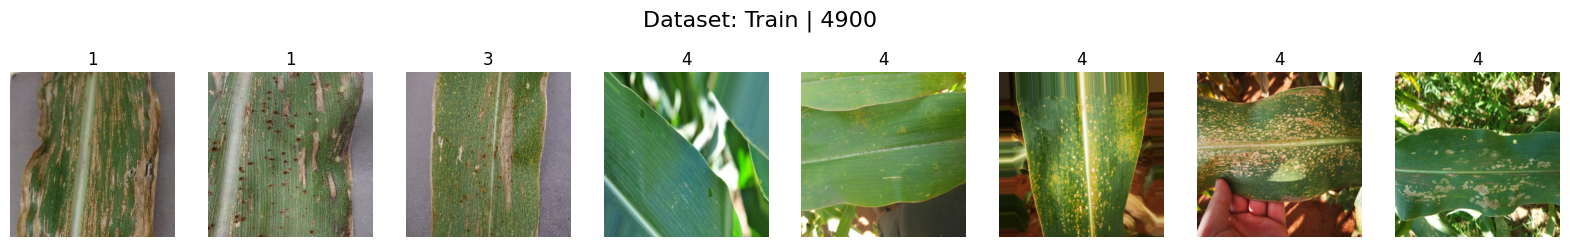

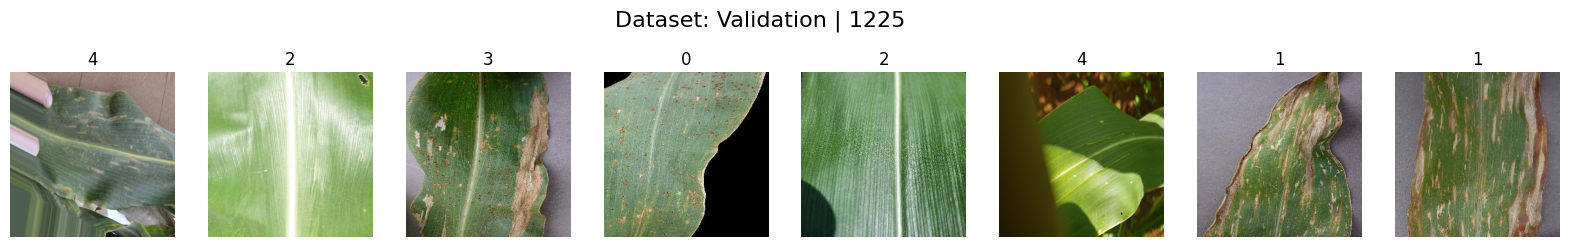

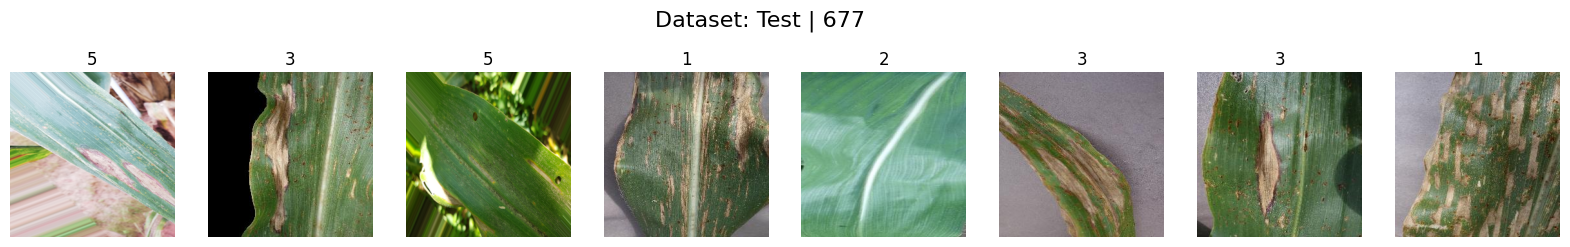

In [10]:
train_df = pd.DataFrame({
    'filename': train_list,
    'class': [classes[os.path.basename(os.path.dirname(img))] for img in train_list]
})

valid_df = pd.DataFrame({
    'filename': valid_list,
    'class': [classes[os.path.basename(os.path.dirname(img))] for img in valid_list]
})

test_df = pd.DataFrame({
    'filename': test_list,
    'class': [classes[os.path.basename(os.path.dirname(img))] for img in test_list]
})

def plot_images(df, dataset, total):
    fig, axs = plt.subplots(1, 8, figsize=(20, 3))
    fig.suptitle(f'Dataset: {dataset} | {total}', fontsize=16)
    for i in range(8):
        img_path = df['filename'][i]
        img = Image.open(img_path)
        img = img.resize((256, 256))
        axs[i].imshow(np.array(img))
        axs[i].set_title(df['class'][i])
        axs[i].axis('off')
    plt.show()

# Randomly shuffle the data from test_df
test_df = test_df.sample(frac=1).reset_index(drop=True)

print(train_df.head())
print(valid_df.head())
print(test_df.head())

print(f'Train: {train_df["class"].value_counts()}')
print(f'Validation: {valid_df["class"].value_counts()}')
print(f'Test: {test_df["class"].value_counts()}')

plot_images(train_df, 'Train', len(train_df))
plot_images(valid_df, 'Validation', len(valid_df))
plot_images(test_df, 'Test', len(test_df))

<h4> Preprocess Data </h4>

In [ ]:
def load_and_preprocess_image(filename, label, img_size=(240, 240)):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = image / 255.0
    return image, label

augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.001),
    tf.keras.layers.RandomZoom(0.001),
    tf.keras.layers.RandomBrightness(0.01),
])

def apply_augmentation(image, label):
    image = augmentation_layers(image, training=True) 
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

def create_dataset(dataframe, batch_size, augment=False, shuffle=True):
    filenames = dataframe['filename'].values
    labels = dataframe['class'].values
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(classes))
    
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(lambda x, y: load_and_preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
 
    if augment:
        dataset = dataset.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def plot_images_fromDataset(dataset, name, batch_size):
    fig, axs = plt.subplots(1, 8, figsize=(20, 3))
    fig.suptitle(f'Dataset: {name} | Batch size: {batch_size} | Batches: {len(dataset)} | Total: {batch_size * len(dataset)} | Normalized: [0, 1] | Labels: One-hot encoded', fontsize=16)
    for i, (image, label) in enumerate(dataset.take(1)):
        for j in range(8):
            axs[j].imshow(image[j])
            axs[j].set_title(label[j].numpy())
            axs[j].axis('off')
    plt.show()

batch_size = 8

train_dataset = create_dataset(train_df, batch_size)
valid_dataset = create_dataset(valid_df, batch_size)
test_dataset = create_dataset(test_df, batch_size)

plot_images_fromDataset(train_dataset, 'Train', batch_size)
plot_images_fromDataset(valid_dataset, 'Validation', batch_size)
plot_images_fromDataset(test_dataset, 'Test', batch_size)

<h2 id="6.-Modelado"> Modelado </h2>

In [ ]:
# Definir la capa personalizada para el Módulo de Atención (Channel + Spatial)
class AttentionModule(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionModule, self).__init__()
        self.shared_dense_1 = Dense(units=1280 // 8, activation='relu')
        self.shared_dense_2 = Dense(units=1280, activation='sigmoid')
        self.conv = Conv2D(filters=1, kernel_size=7, padding='same', activation='sigmoid')

    def channel_attention(self, input_tensor):
        # Atención por canal
        avg_pool = GlobalAveragePooling2D()(input_tensor)
        max_pool = GlobalMaxPooling2D()(input_tensor)
        
        # Aplicar la pequeña MLP (Fully connected) con activación
        avg_out = self.shared_dense_1(avg_pool)
        max_out = self.shared_dense_1(max_pool)
        
        # Combinar ambos resultados
        combined = Add()([avg_out, max_out])
        combined = self.shared_dense_2(combined)
        
        # Reescalar y multiplicar por la entrada
        scale = Reshape((1, 1, input_tensor.shape[-1]))(combined)
        return Multiply()([input_tensor, scale])

    def spatial_attention(self, input_tensor):
        # Atención espacial
        avg_pool = tf.reduce_mean(input_tensor, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(input_tensor, axis=-1, keepdims=True)
        
        # Concatenar los mapas de promedio y máximo
        concat = Concatenate(axis=-1)([avg_pool, max_pool])
        
        # Aplicar convolución para generar el mapa de atención
        attention = self.conv(concat)
        
        return Multiply()([input_tensor, attention])

    def call(self, input_tensor):
        # Aplicar la atención por canal
        x = self.channel_attention(input_tensor)
        
        # Aplicar la atención espacial
        x = self.spatial_attention(x)
        
        return x

# Función para construir el modelo EANet con atención de canal y espacial
def build_EANet():
    # Definir la entrada de la red
    inputs = Input(shape=(240, 240, 3))
    
    # Usar EfficientNetV2 como base (sin la parte superior)
    base_model = EfficientNetV2B0(include_top=False, input_tensor=inputs)
    x = base_model.output
    print(f"Forma de salida de EfficientNetV2: {x.shape}")
    
    # Añadir el módulo de atención (SCA)
    attention_layer = AttentionModule()(x)
    
    # Pooling Global y capa completamente conectada (FC)
    x = GlobalAveragePooling2D()(attention_layer)
    outputs = Dense(6, activation='softmax')(x) 
    
    # Definir el modelo completo
    model = Model(inputs, outputs)
    return model

# Build EANet model
model = build_EANet()

# Show model summary
model.summary()

<h3> Perdida focal </h3>

In [9]:
# Focal Loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
        
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
        
        return tf.reduce_mean(loss, axis=-1)
    
    return focal_loss_fixed

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

Training model 

In [ ]:
# Compile the model
model.compile(optimizer=optimizer, loss=focal_loss(gamma=2., alpha=0.25), metrics=['accuracy'])


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['class']),
    y=train_df['class']
)
class_weights = dict(enumerate(class_weights))

#tf.keras.backend.clear_session()
# Training
model.fit(train_dataset, epochs=13, validation_data=valid_dataset, class_weight=class_weights)

In [ ]:
# 1. Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 2. Generate predictions and classification report
y_true = []
y_pred = []

# Unbatch the dataset to retrieve labels
for images, labels in test_dataset.unbatch():
    y_true.append(np.argmax(labels.numpy()))
    preds = model.predict(tf.expand_dims(images, axis=0))
    y_pred.append(np.argmax(preds))


# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(classes.keys()), yticklabels=list(classes.keys()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# 3. Visualize predictions for 10 random images
def display_predictions(dataset, model, class_names, num_images=10):
    plt.figure(figsize=(15, 15))
    for i, (image_batch, label_batch) in enumerate(dataset.take(1)):  # Take a single batch
        for j in range(num_images):
            if j >= len(image_batch):
                break
            ax = plt.subplot(5, 2, j + 1)
            
            # Select a single image and label from the batch
            image = image_batch[j]
            label = label_batch[j]
            
            # Expand dimensions to create batch shape for prediction
            image = tf.expand_dims(image, axis=0)  # Shape becomes [1, height, width, channels]
            predictions = model.predict(image)
            predicted_label = np.argmax(predictions)
            true_label = np.argmax(label)

            # Display the image
            plt.imshow(tf.squeeze(image))  # Remove the batch dimension for display
            title = f"True: {class_names[true_label]}, Pred: {class_names[predicted_label]}"
            color = "green" if predicted_label == true_label else "red"
            plt.title(title, color=color)
            plt.axis("off")
        plt.show()
        break  # Exit after the first batch

# Call display function with test dataset
display_predictions(test_dataset, model, list(classes.keys()))